<a href="https://colab.research.google.com/github/nwokochachijiokeronald/CE888-Reassessment-project-Resit/blob/main/Fine_Tuned_VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Resit Project: Lungs CT-based Classification for COVID19-vs-Non COVID19**

In [1]:
!git clone https://github.com/UCSD-AI4H/COVID-CT.git

Cloning into 'COVID-CT'...
remote: Enumerating objects: 5463, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 5463 (delta 0), reused 0 (delta 0), pack-reused 5459
Receiving objects: 100% (5463/5463), 1.09 GiB | 25.40 MiB/s, done.
Resolving deltas: 100% (360/360), done.
Checking out files: 100% (1048/1048), done.


In [2]:
# unzip archives  q - quite, n - don't overwrite
!unzip -q -n '/content/COVID-CT/Images-processed/CT_COVID.zip'
!unzip -q -n '/content/COVID-CT/Images-processed/CT_NonCOVID.zip'

In [3]:
import os
path='/content/CT_COVID/'
for count, filename in enumerate(os.listdir(path)): 
    dst ="covid-" + str(count) + ".png"
    src =path+ filename 
    dst =path+ dst 
        
    # rename() function will 
    # rename all the files 
    os.rename(src, dst)
print("Covid Positive cases: ", count)

path='/content/CT_NonCOVID/'
for count, filename in enumerate(os.listdir(path)): 
    dst ="noncovid-" + str(count) + ".png"
    src =path+ filename 
    dst =path+ dst 
        
    # rename() function will 
    # rename all the files 
    os.rename(src, dst)

print("Covid Negative cases: ", count)

Covid Positive cases:  348
Covid Negative cases:  396


In [4]:
base_dir = '/content/covid19_CT'
if not os.path.exists(base_dir): os.mkdir(base_dir)

In [5]:
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir): os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir):os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):os.mkdir(test_dir)

In [6]:
original_dataset_dir_covid = '/content/CT_COVID/'
original_dataset_dir_non_covid = '/content/CT_NonCOVID/'

import shutil
fnames = ['covid-{}.png'.format(i) for i in range(250)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_covid, fname)
    dst = os.path.join(train_dir, fname)
    #print(src,dst)
    shutil.copyfile(src, dst)
    
fnames = ['covid-{}.png'.format(i) for i in range(250, 300)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_covid, fname)
    dst = os.path.join(validation_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['covid-{}.png'.format(i) for i in range(300, 348)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_covid, fname)
    dst = os.path.join(test_dir, fname)
    shutil.copyfile(src, dst)

In [7]:
fnames = ['noncovid-{}.png'.format(i) for i in range(250)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_non_covid, fname)
    dst = os.path.join(train_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['noncovid-{}.png'.format(i) for i in range(250, 300)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_non_covid, fname)
    dst = os.path.join(validation_dir, fname)
    shutil.copyfile(src, dst)

fnames = ['noncovid-{}.png'.format(i) for i in range(300, 348)]
for fname in fnames:
    src = os.path.join(original_dataset_dir_non_covid, fname)
    dst = os.path.join(test_dir, fname)
    shutil.copyfile(src, dst)

In [8]:
import cv2
import numpy as np
from random import shuffle

IMG_SIZE = 224
LR = 1e-4

In [9]:
def label_img(img):
    word_label = img.split('-')[0]
    if word_label == 'covid': return 1
    elif word_label == 'noncovid': return 0

In [10]:
def createDataSplitSet(datapath):
    X=[]
    y=[]

    for img in os.listdir(datapath):
        label = label_img(img)
        path = os.path.join(datapath, img)
        image = cv2.resize(cv2.imread(path), (IMG_SIZE, IMG_SIZE))
        image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        X.append(np.array(image))
        y.append(label)

    return np.array(X), np.array(y)

In [11]:
train_X, train_y = createDataSplitSet(train_dir)
val_X, val_y = createDataSplitSet(validation_dir)
test_X, test_y = createDataSplitSet(test_dir)
#print(train_X.shape)
#print(val_X.shape)
#print(test_X.shape)

In [12]:
#VGG19
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.models import Model

img_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

In [13]:
base_model = VGG19(weights='imagenet', input_tensor=img_input)
base_model.summary()

574726144/574710816 [==============================] - 12s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

In [14]:
last_layer = base_model.get_layer('block5_pool').output
x = Flatten(name='flatten')(last_layer)
x = Dropout(0.5)(x)
x = Dense(2084, activation='relu', name='fc2')(x)
out = Dense(1, activation='sigmoid', name='output')(x)  
model = Model(img_input, out)

for layer in model.layers[:-3]:
	layer.trainable = False

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [31]:
model.compile(loss='binary_crossentropy',
              optimizer= 'adam',
              metrics=['acc'])

In [32]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
my_callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath='vgg19_model.h5', save_best_only=True),
]

In [33]:
history = model.fit(train_X, train_y,
                              batch_size=20,
                              epochs=100, 
                              validation_data=(val_X, val_y),
                              callbacks=my_callbacks)

Epoch 1/100
25/25 [==============================] - 9s 332ms/step - loss: 0.1683 - acc: 0.9380 - val_loss: 0.3173 - val_acc: 0.8800
Epoch 2/100
25/25 [==============================] - 8s 323ms/step - loss: 0.0876 - acc: 0.9660 - val_loss: 0.3373 - val_acc: 0.9000
Epoch 3/100
25/25 [==============================] - 8s 318ms/step - loss: 0.0880 - acc: 0.9680 - val_loss: 0.3077 - val_acc: 0.8900
Epoch 4/100
25/25 [==============================] - 8s 321ms/step - loss: 0.0693 - acc: 0.9780 - val_loss: 0.3482 - val_acc: 0.8700
Epoch 5/100
25/25 [==============================] - 8s 322ms/step - loss: 0.0947 - acc: 0.9620 - val_loss: 0.3206 - val_acc: 0.8800
Epoch 6/100
25/25 [==============================] - 8s 322ms/step - loss: 0.0437 - acc: 0.9820 - val_loss: 0.4829 - val_acc: 0.8300
Epoch 7/100
25/25 [==============================] - 8s 323ms/step - loss: 0.1401 - acc: 0.9460 - val_loss: 0.3659 - val_acc: 0.8900
Epoch 8/100
25/25 [==============================] - 8s 321ms/step - 

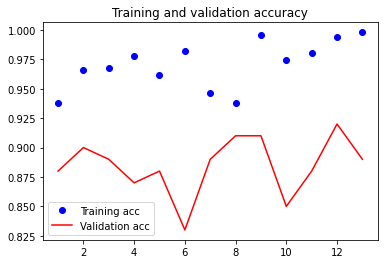

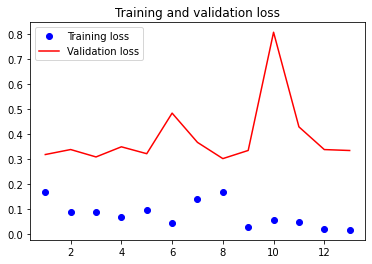

In [34]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [35]:
from sklearn.metrics import accuracy_score

## Test Accuracy
predictions = model.predict(test_X)
ypred = predictions > 0.5
test_acc = accuracy_score(test_y, ypred)

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

precision, recall, f1score, _ = precision_recall_fscore_support(test_y, ypred, average='binary')

auc = roc_auc_score(test_y, ypred)

print("Train Accuracy:\t", acc[-1])
print("Val Accuracy:\t", val_acc[-1])
print("Test Accuracy:\t", test_acc)
print("Precision:\t", precision)
print("Recall:\t\t", recall)
print("F1 Score:\t", f1score)
print("AUC:\t\t", auc)

Train Accuracy:	 0.9980000257492065
Val Accuracy:	 0.8899999856948853
Test Accuracy:	 0.8541666666666666
Precision:	 0.8695652173913043
Recall:		 0.8333333333333334
F1 Score:	 0.851063829787234
AUC:		 0.8541666666666667
